In [1]:
!pip install pillow

# Data Preprocessing

### Converting all images to `jpg`

In [1]:
import os
import time
import multiprocessing
from PIL import Image
from joblib import Parallel, delayed
import dask.bag as db
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
# --- CONFIGURATION ---
# Point this to your main Data folder
DATA_DIR = "/home/padala.r/MyProject/Data" 

# Number of CPUs to use (Set to 4 for your cluster request)
NUM_WORKERS = 4 
# --------------------- #

def convert_worker(file_path):
    """
    Worker function: Converts a single file to JPG in the same directory.
    """
    try:
        # Generate new filename (e.g., image.tiff -> image.jpg)
        file_root, _ = os.path.splitext(file_path)
        new_path = file_root + ".jpg"

        # Skip if the JPG already exists to avoid redundant work
        if os.path.exists(new_path):
            return 0

        with Image.open(file_path) as img:
            # Convert to RGB (Required for PNG/TIFF to JPG)
            img = img.convert('RGB')
            # Save as JPG (Quality 85 is a good balance)
            img.save(new_path, "JPEG", quality=85)
            
        # OPTIONAL: Uncomment the line below to DELETE the original file after conversion
        os.remove(file_path) 
        
        return 1
    except Exception as e:
        print(f"Error converting {file_path}: {e}")
        return 0

def main():
    print(f"Scanning {DATA_DIR} for images...")
    
    # 1. Collect all non-JPG images
    tasks = []
    for root, dirs, files in os.walk(DATA_DIR):
        for filename in files:
            # Process TIFF, PNG, BMP, etc.
            if filename.lower().endswith(('.tif', '.tiff', '.png', '.bmp')):
                full_path = os.path.join(root, filename)
                tasks.append(full_path)

    total_files = len(tasks)
    print(f"Found {total_files} images to convert.")
    
    if total_files == 0:
        print("No images found to convert!")
        return

    print(f"Starting conversion with {NUM_WORKERS} CPUs...")
    start_time = time.time()

    # 2. Run Parallel Conversion
    with multiprocessing.Pool(processes=NUM_WORKERS) as pool:
        # map_async + chunksize helps with very large lists (300k images)
        results = pool.map_async(convert_worker, tasks, chunksize=100)
        
        # Monitor progress (Optional visual feedback)
        while not results.ready():
            print("Processing...", end='\r')
            time.sleep(1)
            
        final_results = results.get()

    end_time = time.time()
    duration = end_time - start_time
    success_count = sum(final_results)

    print(f"\nDone! Converted {success_count} images.")
    print(f"Total Time: {duration:.2f} seconds")

if __name__ == "__main__":
    main()

Scanning /home/padala.r/MyProject/Data for images...
Found 308942 images to convert.
Starting conversion with 4 CPUs...
Processing...
Done! Converted 308942 images.
Total Time: 2181.25 seconds


### Checking the size of the Image

Found: 312910 Number-start, 290 Normal-start, 934 OSCC-start images.


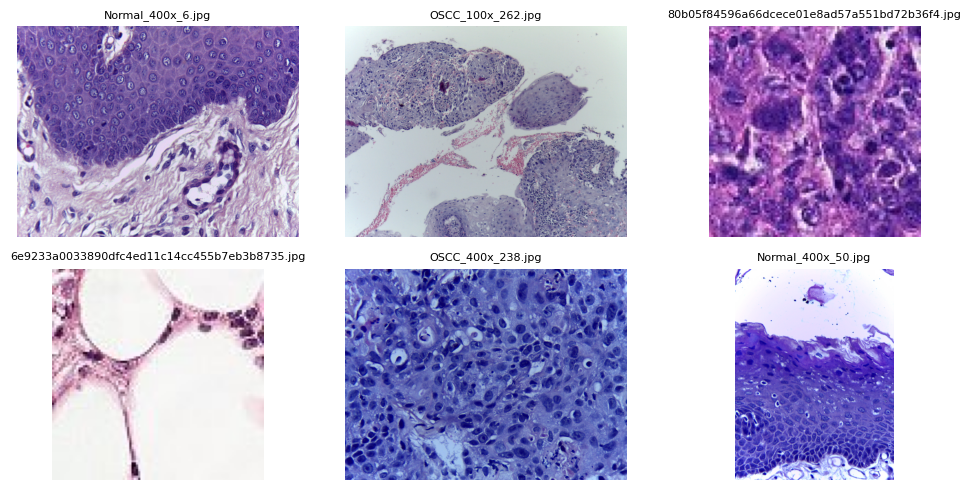

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Configuration
INPUT_ROOT = "Data"  

# 1. Create buckets for specific file types
digits_imgs = []
normal_imgs = []
oscc_imgs = []

# 2. Scan and Categorize
for root, dirs, files in os.walk(INPUT_ROOT):
    for file in files:
        if file.lower().endswith(('.jpg', '.tif')):
            full_path = os.path.join(root, file)
            
            # Category 1: Starts with a Number
            # if file[0].isdigit():
            #     digits_imgs.append(full_path)
            # Category 2: Starts with Normal
            if file.lower().startswith("normal"):
                normal_imgs.append(full_path)
            # Category 3: Starts with OSCC
            elif file.lower().startswith("oscc"):
                oscc_imgs.append(full_path)
            else:
                digits_imgs.append(full_path)

# 3. Select 2 from each category (Safety check included)
selection = []

# Helper function to safe sample
def safe_sample(img_list, k):
    if len(img_list) < k:
        return img_list # Take all if not enough
    return random.sample(img_list, k)

selection.extend(safe_sample(digits_imgs, 2))
selection.extend(safe_sample(normal_imgs, 2))
selection.extend(safe_sample(oscc_imgs, 2))

# Shuffle them so they aren't always in the same order on the grid
random.shuffle(selection)

print(f"Found: {len(digits_imgs)} Number-start, {len(normal_imgs)} Normal-start, {len(oscc_imgs)} OSCC-start images.")

# 4. Plot them (Small Figure Size)
plt.figure(figsize=(10, 5))

for i, img_path in enumerate(selection):
    try:
        img = Image.open(img_path)
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        
        file_name = os.path.basename(img_path)
        plt.title(file_name, fontsize=8)
        plt.axis('off')
        
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()

In [15]:
print(f"{'Category':<15} | {'Filename':<35} | {'Size (WxH)':<15}")
print("-" * 70)

for img_path in selection:
    try:
        with Image.open(img_path) as img:
            file_name = os.path.basename(img_path)
            
            # Determine category for display
            if file_name.lower().startswith("normal"):
                cat = "Normal"
            elif file_name.lower().startswith("oscc"):
                cat = "OSCC"
            else:
                cat = "Other"

            # Truncate filename if needed
            if len(file_name) > 33:
                file_name = file_name[:30] + "..."
                
            print(f"{cat:<15} | {file_name:<35} | {img.size}")
            
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

Category        | Filename                            | Size (WxH)     
----------------------------------------------------------------------
Normal          | Normal_400x_6.jpg                   | (2048, 1536)
OSCC            | OSCC_100x_262.jpg                   | (2048, 1536)
Other           | 80b05f84596a66dcece01e8ad57a55...   | (96, 96)
Other           | 6e9233a0033890dfc4ed11c14cc455...   | (96, 96)
OSCC            | OSCC_400x_238.jpg                   | (2048, 1536)
Normal          | Normal_400x_50.jpg                  | (1536, 2048)


### Changing all images to same size

In [16]:
import os
from multiprocessing import Pool
from PIL import Image

# Configuration
TARGET_SIZE = (96, 96)

def resize_overwrite_worker(file_path):
    """
    1. Opens image
    2. Resizes to 96x96
    3. Saves as .jpg (Overwriting if name matches)
    4. Deletes original if extension was different (e.g. .tiff)
    """
    try:
        # Open and Resize
        with Image.open(file_path) as img:
            img = img.convert('RGB')
            img_resized = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
            
            # Construct new filename with .jpg extension
            file_root, _ = os.path.splitext(file_path)
            new_path = file_root + ".jpg"
            
            # Save the new file
            img_resized.save(new_path, "JPEG", quality=95)
            
        # CLEANUP: If the original file was NOT a jpg (e.g., .tiff), delete it.
        # If it was already .jpg, we just overwrote it, so no delete needed.
        if new_path != file_path:
            os.remove(file_path)
            
        return 1 # Success
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return 0 # Fail

In [17]:
import time

# 1. Combine the lists from the previous step
# (Assumes digits_imgs, normal_imgs, and oscc_imgs are still in memory)
try:
    all_tasks = digits_imgs + normal_imgs + oscc_imgs
    print(f"Combined List: {len(digits_imgs)} (Numbers) + {len(normal_imgs)} (Normal) + {len(oscc_imgs)} (OSCC)")
    print(f"Total images to resize: {len(all_tasks)}")
except NameError:
    print("Error: The lists 'digits_imgs', 'normal_imgs', etc. are not defined.")
    print("Please run the previous 'Categorize' cell again to populate them.")
    all_tasks = []

# 2. Run Parallel Processing
if len(all_tasks) > 0:
    print(f"Starting in-place resizing on 4 CPUs...")
    start_time = time.time()
    
    with Pool(processes=4) as pool:
        # map_async is efficient for large lists
        results = pool.map(resize_overwrite_worker, all_tasks)
        
    duration = time.time() - start_time
    success_count = sum(results)
    
    print(f"\nDone! Successfully resized {success_count} images.")
    print(f"Total Time: {duration:.2f} seconds")
    
    # 3. Quick Verification
    # Check the size of the first image in the list to prove it worked
    test_img = all_tasks[0]
    # Ensure we check the .jpg version in case the extension changed
    root, _ = os.path.splitext(test_img)
    test_path = root + ".jpg"
    
    if os.path.exists(test_path):
        with Image.open(test_path) as img:
            print(f"\nVerification - {os.path.basename(test_path)} size: {img.size}")

Combined List: 312910 (Numbers) + 290 (Normal) + 934 (OSCC)
Total images to resize: 314134
Starting in-place resizing on 4 CPUs...
Error processing Data/test/OSCC/1b88fcdab85abe38920cd24ab7460a7e70612fea.jpg: cannot identify image file 'Data/test/OSCC/1b88fcdab85abe38920cd24ab7460a7e70612fea.jpg'

Done! Successfully resized 314133 images.
Total Time: 724.50 seconds

Verification - 0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.jpg size: (96, 96)


In [18]:
print(f"{'Category':<15} | {'Filename':<35} | {'Size (WxH)':<15}")
print("-" * 70)

for img_path in selection:
    try:
        with Image.open(img_path) as img:
            file_name = os.path.basename(img_path)
            
            # Determine category for display
            if file_name.lower().startswith("normal"):
                cat = "Normal"
            elif file_name.lower().startswith("oscc"):
                cat = "OSCC"
            else:
                cat = "Other"

            # Truncate filename if needed
            if len(file_name) > 33:
                file_name = file_name[:30] + "..."
                
            print(f"{cat:<15} | {file_name:<35} | {img.size}")
            
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

Category        | Filename                            | Size (WxH)     
----------------------------------------------------------------------
Normal          | Normal_400x_6.jpg                   | (96, 96)
OSCC            | OSCC_100x_262.jpg                   | (96, 96)
Other           | 80b05f84596a66dcece01e8ad57a55...   | (96, 96)
Other           | 6e9233a0033890dfc4ed11c14cc455...   | (96, 96)
OSCC            | OSCC_400x_238.jpg                   | (96, 96)
Normal          | Normal_400x_50.jpg                  | (96, 96)


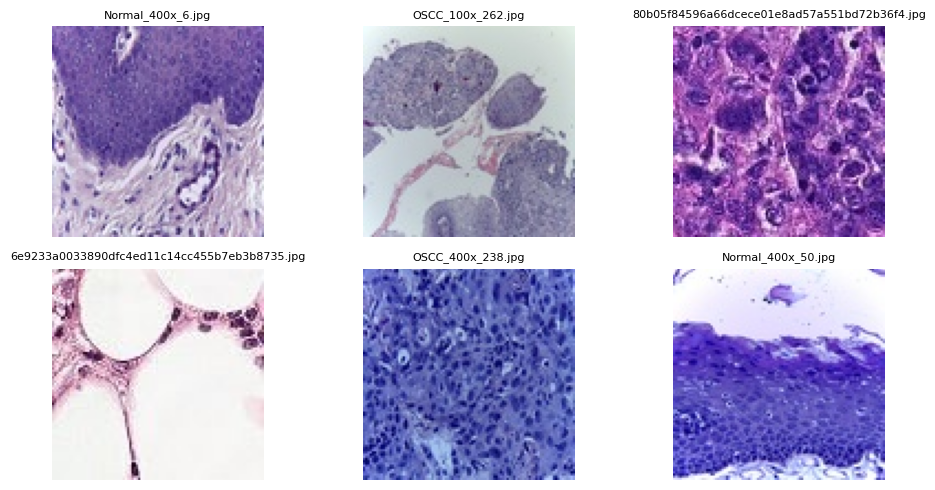

In [19]:
plt.figure(figsize=(10, 5))

for i, img_path in enumerate(selection):
    try:
        img = Image.open(img_path)
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        
        file_name = os.path.basename(img_path)
        plt.title(file_name, fontsize=8)
        plt.axis('off')
        
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()